In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

#### Use my data (for actual final analysis)

In [4]:
# Generate fake ensembles. 
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi']
    afpi_boot = twopt_data['afpi']
    ampi_ens.populate_ensemble(ampi_boot, ens_idx)
    afpi_ens.populate_ensemble(afpi_boot, ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's data

In [ ]:
# David's data
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# enter this data in format [ens_idx, op_idx] with pairs (mu, sigma)
a4_matelem_david = np.array([
    [[-0.04648, 0.00025], [-0.07996, 0.00057], [0.002768, 0.000013], [-0.14345, 0.00080], [0.01951, 0.00014]], 
    [[-0.03903, 0.00026], [-0.06667, 0.00065], [0.0013953, 0.0000095], [-0.12229, 0.00081], [0.01633, 0.00016]], 
    [[-0.01476, 0.00011], [-0.02323, 0.00024], [0.0006677, 0.0000043], [-0.04591, 0.00036], [0.005778, 0.000061]], 
    [[-0.013052, 0.000094], [-0.02059, 0.00020], [0.0004511, 0.0000028], [-0.04087, 0.00030], [0.005132, 0.000050]], 
    [[-0.011753, 0.000091], [-0.01847, 0.00021], [0.0002745, 0.0000022], [-0.03705, 0.00029], [0.004608, 0.000053]]
])

# Generate fake ensembles. 
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    for i in range(n_ops):
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.gen_fake_ensemble_axis(a4_matelem_david[ens_idx, i, 0], a4_matelem_david[ens_idx, i, 1], ens_idx)
        a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    # This reads in david's values for ampi, afpi and should be used for testing.
    ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
    afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's 2pt function data with my matrix elements

In [4]:
# Generate fake ensembles. 
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    # This reads in david's values for ampi, afpi and should be used for testing.
    ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
    afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Propagate error and print data

In [5]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
mat_elem_mu = [[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)]
mat_elem_sigma = [[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)]
mpi_mu = [mpi_ens[i].compute_mean() for i in range(n_ens)]
mpi_sigma = [mpi_ens[i].compute_std() for i in range(n_ens)]
fpi_mu = [fpi_ens[i].compute_mean() for i in range(n_ens)]
fpi_sigma = [fpi_ens[i].compute_std() for i in range(n_ens)]
eps_mu = [eps_sq_ens[i].compute_mean() for i in range(n_ens)]
eps_sigma = [eps_sq_ens[i].compute_std() for i in range(n_ens)]
eps_phys_mu = [eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)]
eps_phys_sigma = [eps_sq_phys_ens[i].compute_std() for i in range(n_ens)]
ainv_ens_mu = [ainv_ens[i].compute_mean() for i in range(n_ens)]
ainv_ens_sigma = [ainv_ens[i].compute_std() for i in range(n_ens)]
asq_ens_mu = [asq_ens[i].compute_mean() for i in range(n_ens)]
asq_ens_sigma = [asq_ens[i].compute_std() for i in range(n_ens)]

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print(labels[op_idx]+': '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.43117842371940734 \pm 0.0016610268771865217 GeV
f_pi: 0.16380371766606175 \pm 0.0007431766780047052 GeV
epsilon_pi_sq: 0.08775611918880351 \pm 0.00014692852238760236
epsilon_pi_phys_sq (to plot at): 0.13844277519238812 \pm 0.0007141972090504217
O1: -0.029388761832661838 \pm 0.0003864576901379262 (GeV)^4
O2: -0.10125344202213361 \pm 0.001455203565467493 (GeV)^4
O3: 0.0035042343828550065 \pm 4.355682612377701e-05 (GeV)^4
O1p: -0.09081412990659629 \pm 0.0012002947719437227 (GeV)^4
O2p: 0.024706950436744864 \pm 0.00035511931985637634 (GeV)^4


24I/ml_0p005
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.3414729099541673 \pm 0.0013668176772072406 GeV
f_pi: 0.1516359528223049 \pm 0.0006380479963436464 GeV
epsilon_pi_sq: 0.06422713735765427 \pm 3.457313140

<IPython.core.display.Javascript object>


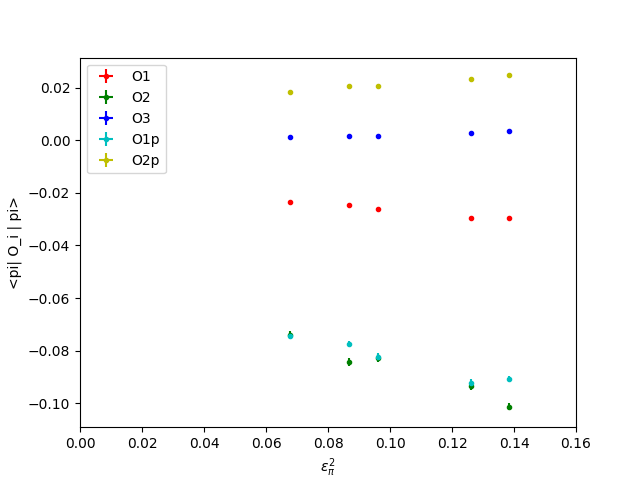

In [6]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
plt.figure()
for i in range(n_ops):
    plt.errorbar(eps_phys_mu, [mat_elem_mu[j][i] for j in range(n_ens)], xerr = eps_phys_sigma, yerr = [mat_elem_sigma[j][i] for j in range(n_ens)], fmt = '.', c = colors[i], label = labels[i])
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('<pi| O_i | pi>')
plt.legend()
plt.xlim((0, 0.16))
# plt.ylim((-0.08, 0.02))
plt.show()

## Perform the fit

In [9]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
#     if op_idx == 2:    # for O3
#         return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
#     return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)
# this mirrors David's code, but it should be a bug: inputs L = 32 for the f1 piece regardless of ensemble.
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, 32, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, 32, ainv)

In [10]:
# Define functional fit forms for the operators (these agree with David's functions)
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

In [11]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [12]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O1
[-1.31305808 -1.70031796 -0.83206842]
O2
[10.34133389 -4.90465666 -1.09804722]
O3
[50.69485518  0.60704052  1.47976297]
O1p
[-1.48317617 -5.46507774 -1.07455094]
O2p
[ 7.57188519  1.25199414 -1.08153306]


#### Fit to full data

In [13]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

Operator O1
Ensemble 0, boot 0
-1.7650673916886643 -1.722121834424986 -0.9130422693685878
Ensemble 0, boot 1
-0.7505966948560202 -1.6733875083156662 -0.7287488922457342
Ensemble 0, boot 2
-1.4609432502435984 -1.7075240991278078 -0.8592864594007065
Ensemble 0, boot 3
-0.16217367209745945 -1.6457429771131216 -0.6185577824779259
Ensemble 0, boot 4
-1.100194841270718 -1.6900165282381048 -0.7930185647914227
Ensemble 0, boot 5
-2.0928640427100045 -1.738440458502436 -0.9723818950046222
Ensemble 0, boot 6
-2.251295858495533 -1.7463720851820705 -1.0007729724003631
Ensemble 0, boot 7
-0.61500256759938 -1.6669784364423075 -0.7035800480681178
Ensemble 0, boot 8
-0.8143219419336278 -1.6763792129965465 -0.7404025619439834
Ensemble 0, boot 9
-1.620670230044542 -1.7156539629570837 -0.8898394926214177
Ensemble 0, boot 10
0.31955483399738155 -1.6235251446585777 -0.5270024314232645
Ensemble 0, boot 11
-2.060356047407038 -1.7366795853754309 -0.9659322306948356
Ensemble 0, boot 12
-1.5618898121674032 -1.71

-1.3299407036466784 -1.700242194797696 -0.8290499645610291
Ensemble 2, boot 5
0.17658376820806018 -1.7038795435825045 -1.0822612543561456
Ensemble 2, boot 6
0.6630546854598038 -1.7050099619928532 -1.1636495322374283
Ensemble 2, boot 7
-2.900766948981556 -1.6959804728924726 -0.5642504069780429
Ensemble 2, boot 8
-2.731725905065454 -1.6967395317983236 -0.591160635686581
Ensemble 2, boot 9
-1.9639535515642035 -1.698560049708355 -0.7226257728290315
Ensemble 2, boot 10
-4.751795685422974 -1.690596852546311 -0.2483453134196741
Ensemble 2, boot 11
0.6823309136559902 -1.7050396308247402 -1.1670675194129454
Ensemble 2, boot 12
-1.071203411668887 -1.7009115555061236 -0.8725582914775848
Ensemble 2, boot 13
-0.9204991891552964 -1.7012507347340082 -0.8982280103250218
Ensemble 2, boot 14
-0.2906812910846573 -1.702791717458157 -1.003916970982485
Ensemble 2, boot 15
-0.27458406207157804 -1.702941927097425 -1.007135349504617
Ensemble 2, boot 16
-0.5557862502996973 -1.702193231399883 -0.959516719277639


-1.6704035722503616 -1.7510291613538678 -1.014395839037009
Ensemble 4, boot 9
-1.3887491722152825 -1.7106988861403154 -0.8705049408644946
Ensemble 4, boot 10
-2.2255582724221323 -1.8339383351912113 -1.2886801487088295
Ensemble 4, boot 11
-1.0240567060930903 -1.6607975207094128 -0.6813265554552156
Ensemble 4, boot 12
-0.9984763821123114 -1.6582502996803665 -0.6721414199026821
Ensemble 4, boot 13
-1.0910881118565463 -1.6702346509846477 -0.7185356498285902
Ensemble 4, boot 14
-0.8375658869049665 -1.6367672712365795 -0.5868674821719867
Ensemble 4, boot 15
-1.4409532804453578 -1.7183266736151777 -0.898235412496407
Ensemble 4, boot 16
-1.5615310272793372 -1.734705296282745 -0.9570587963384796
Ensemble 4, boot 17
-1.0832274683087435 -1.6694618718003222 -0.7154595950188276
Ensemble 4, boot 18
-1.2293923851449564 -1.6879746607702835 -0.7858045342117327
Ensemble 4, boot 19
-1.546144464349343 -1.7335172433800154 -0.9526869614484367
Ensemble 4, boot 20
-1.7678623970463558 -1.7647380529662267 -1.06

10.980691798344639 -4.925914028487875 -1.208694698862328
Ensemble 1, boot 14
11.106177589523785 -4.929982451449994 -1.2283086982119198
Ensemble 1, boot 15
10.978761642038712 -4.925652423597818 -1.2067151482823764
Ensemble 1, boot 16
9.668261807699153 -4.882577906647452 -0.9852321288869214
Ensemble 1, boot 17
9.403822669118066 -4.873994918439305 -0.9408437247969322
Ensemble 1, boot 18
8.60131650426431 -4.847870789209068 -0.8027696554195838
Ensemble 1, boot 19
11.4830415149929 -4.943368426145743 -1.3026821004813645
Ensemble 1, boot 20
12.400467369157726 -4.973995446659346 -1.4559826933450926
Ensemble 1, boot 21
10.254503365618032 -4.90181352707737 -1.0845592914673232
Ensemble 1, boot 22
9.476801829894747 -4.875913006468449 -0.9463736184458765
Ensemble 1, boot 23
10.933925444666057 -4.923922560707458 -1.1968220112944958
Ensemble 1, boot 24
10.01649407479382 -4.89370394391648 -1.0400417795925916
Ensemble 1, boot 25
10.792399368956396 -4.91928511988928 -1.1721115812698082
Ensemble 1, boot 2

9.604207184631782 -4.953640609337746 -1.0753952940497489
Ensemble 3, boot 21
10.979742012174201 -4.865999217774481 -1.1149472590690441
Ensemble 3, boot 22
10.025317849426731 -4.92704696309567 -1.087299374608182
Ensemble 3, boot 23
10.1979230635764 -4.913774692359844 -1.0937429166777568
Ensemble 3, boot 24
11.272083192533874 -4.845037933113553 -1.1253678225295436
Ensemble 3, boot 25
10.243535057944177 -4.911487753057557 -1.0947628260267142
Ensemble 3, boot 26
10.527347362427433 -4.8928671403697495 -1.1032807529411377
Ensemble 3, boot 27
10.199064115513861 -4.915421680888187 -1.0926002231688814
Ensemble 3, boot 28
9.914838863059149 -4.93207006074799 -1.0857475502054292
Ensemble 3, boot 29
11.819108862537659 -4.813142073100216 -1.1394566620788007
Ensemble 3, boot 30
9.994770404286506 -4.925462720307758 -1.0890201387228566
Ensemble 3, boot 31
11.12834109357787 -4.855818587776016 -1.119857963580392
Ensemble 3, boot 32
10.028054200909999 -4.924345275240772 -1.089276153698744
Ensemble 3, boot

51.712594157721 0.6013033113577838 1.6482809647373293
Ensemble 0, boot 28
50.465772201216105 0.608709847861102 1.4325227378365601
Ensemble 0, boot 29
49.18294632548901 0.616758799046655 1.2052469313567684
Ensemble 0, boot 30
51.08452316125259 0.6045373746081317 1.5519238955093195
Ensemble 0, boot 31
49.366327159811455 0.6157326895758903 1.234364189768294
Ensemble 0, boot 32
49.774860207094726 0.6124799585452828 1.3233061685485923
Ensemble 0, boot 33
45.71706939802412 0.6371134127378086 0.6471088504499528
Ensemble 0, boot 34
47.44890172022044 0.6271667115529864 0.9175348533337241
Ensemble 0, boot 35
47.786007204553094 0.624239100820579 0.9934684584513014
Ensemble 0, boot 36
48.266998595679524 0.6214978296090399 1.0698881263324873
Ensemble 0, boot 37
53.61343414767344 0.5903425495514572 1.978081191725248
Ensemble 0, boot 38
52.730253631387846 0.5955886304464134 1.8192030626678093
Ensemble 0, boot 39
51.923270141277065 0.6001718898023188 1.6820493743324338
Ensemble 0, boot 40
52.997034647

49.56304206070065 0.6040599206674607 1.847309971672127
Ensemble 2, boot 37
49.33409699452077 0.6035459757496127 1.8962029925493493
Ensemble 2, boot 38
49.99800379978519 0.6052316277572669 1.7083945179784898
Ensemble 2, boot 39
51.46121204512727 0.6090372657670161 1.2697728138837392
Ensemble 2, boot 40
47.847829072801105 0.599677481262911 2.2748970868590326
Ensemble 2, boot 41
48.83329948839999 0.602238136507977 1.9935795701801242
Ensemble 2, boot 42
52.98683652907355 0.6128483646535945 0.8152663372015221
Ensemble 2, boot 43
51.79315619910514 0.6097058241012024 1.1601988299239125
Ensemble 2, boot 44
44.99010014170639 0.5923692240235711 3.098533540672619
Ensemble 2, boot 45
48.86771852076727 0.602329917455121 2.0093111474654077
Ensemble 2, boot 46
53.043727004181044 0.6131066648293765 0.8457548708873249
Ensemble 2, boot 47
51.499595075478936 0.60896080455398 1.267827701657089
Ensemble 2, boot 48
46.63499195680389 0.5965446850544498 2.6502907581065562
Ensemble 2, boot 49
49.32813290130383

47.84980250937893 0.634999126097064 0.6469567875875091
Ensemble 4, boot 46
53.88655568408243 0.5786477624353884 2.4096231098490146
Ensemble 4, boot 47
52.844025598991266 0.5881241452671506 2.09166777004837
Ensemble 4, boot 48
49.718056535757995 0.6166506844577202 1.1863029470570021
Ensemble 4, boot 49
50.11761304147805 0.6133675003074536 1.2880010192852562
Operator O1p
Ensemble 0, boot 0
-1.9236086462360436 -5.53381995383914 -1.151043923099195
Ensemble 0, boot 1
-0.9489457079463168 -5.382187009492906 -0.9793840595505036
Ensemble 0, boot 2
-1.64572180509644 -5.490786530735121 -1.103617771240341
Ensemble 0, boot 3
-0.35452490632516753 -5.291657860859595 -0.8714177722505808
Ensemble 0, boot 4
-1.2668017291537235 -5.431128461423673 -1.0359946486069693
Ensemble 0, boot 5
-2.2540660524076124 -5.587324852341254 -1.209375130041951
Ensemble 0, boot 6
-2.3982626847650694 -5.61038708968173 -1.233993620055784
Ensemble 0, boot 7
-0.8123768721848893 -5.361255189886894 -0.9547968574503822
Ensemble 0,

-0.2820233194250616 -5.473672233187205 -1.2746897094158065
Ensemble 2, boot 1
-2.2520715335430115 -5.458670273464727 -0.946170036461023
Ensemble 2, boot 2
-0.8298341899529719 -5.469780803005796 -1.18384514719883
Ensemble 2, boot 3
-4.528717093518029 -5.440268130561001 -0.560802822435064
Ensemble 2, boot 4
-1.5339968174992704 -5.464586790547602 -1.0658730603618396
Ensemble 2, boot 5
0.006430080402227515 -5.47566440621477 -1.322693212710344
Ensemble 2, boot 6
0.46963527570738667 -5.478840902442571 -1.3995721167609656
Ensemble 2, boot 7
-3.0542845810274994 -5.452163956748165 -0.8118389242765068
Ensemble 2, boot 8
-2.8962670394551 -5.454469191649243 -0.8365002999872855
Ensemble 2, boot 9
-2.0985930040862724 -5.460066703108073 -0.9720150776021506
Ensemble 2, boot 10
-4.874425250155796 -5.4361757881111945 -0.5038115246835004
Ensemble 2, boot 11
0.4895716173936174 -5.4789409529964495 -1.4030175259123403
Ensemble 2, boot 12
-1.2734152395959497 -5.466630622453053 -1.1093291440521271
Ensemble 2,

-0.9677106917004192 -5.24419817798179 -0.819424207001706
Ensemble 4, boot 6
-1.1569987257627081 -5.321815472481962 -0.9110516576137404
Ensemble 4, boot 7
-1.9096061133008062 -5.663358572942936 -1.2857496695275508
Ensemble 4, boot 8
-1.8314973650965753 -5.6257906694676425 -1.247072845667666
Ensemble 4, boot 9
-1.549597799859017 -5.494580617670607 -1.1072161258091013
Ensemble 4, boot 10
-2.3806595694455592 -5.892180562475388 -1.5102338904891184
Ensemble 4, boot 11
-1.2126189039731328 -5.344557078594758 -0.9374439403712742
Ensemble 4, boot 12
-1.1657713344551706 -5.3272825424858885 -0.9181135253361012
Ensemble 4, boot 13
-1.261542959268838 -5.367444131323152 -0.9645529009177147
Ensemble 4, boot 14
-1.0292055365303383 -5.267465256103472 -0.8472366855467299
Ensemble 4, boot 15
-1.5923112856058041 -5.515180142020473 -1.1296081149461699
Ensemble 4, boot 16
-1.721964541295455 -5.5722096352731905 -1.1908490299400947
Ensemble 4, boot 17
-1.2727161971417493 -5.373316542414634 -0.9711613987932808


7.576744959203826 1.2519581573904148 -1.0792220688647371
Ensemble 1, boot 12
7.98492057075772 1.2555107867942776 -1.1510154347490278
Ensemble 1, boot 13
8.238373820743917 1.2577457035259114 -1.1960862334566134
Ensemble 1, boot 14
8.310973729700109 1.2583500230855131 -1.2070850046503399
Ensemble 1, boot 15
8.167220254196415 1.257086628576655 -1.1827182335896178
Ensemble 1, boot 16
6.890922304772758 1.2461852038122938 -0.9671455281637974
Ensemble 1, boot 17
6.662036407256434 1.244254049496448 -0.9287205374847131
Ensemble 1, boot 18
5.782854153921382 1.2368297592587516 -0.7783154459310633
Ensemble 1, boot 19
8.697436074563347 1.2618780697690004 -1.280586756906128
Ensemble 1, boot 20
9.569081509772476 1.2694454654677383 -1.4264680218498396
Ensemble 1, boot 21
7.525285926602947 1.2515955623261557 -1.0745727306667512
Ensemble 1, boot 22
6.745367976948351 1.244866988510808 -0.9379104991046737
Ensemble 1, boot 23
8.14626632895836 1.2568532891348456 -1.177426703556666
Ensemble 1, boot 24
7.2251

7.697114904542087 1.249988056920386 -1.0848562689307593
Ensemble 3, boot 20
6.86437705437775 1.2642897303066274 -1.0589770036708082
Ensemble 3, boot 21
8.184674489730238 1.242090057608511 -1.098870308752978
Ensemble 3, boot 22
7.261144035786492 1.2576484870692328 -1.0708379128754593
Ensemble 3, boot 23
7.433177278399108 1.2543178982802305 -1.0771731619622888
Ensemble 3, boot 24
8.438804617172249 1.2373765043454068 -1.1081597742667457
Ensemble 3, boot 25
7.490896896571307 1.2534668660420878 -1.0787151765242913
Ensemble 3, boot 26
7.750040362377055 1.2490072204430918 -1.0868202915625504
Ensemble 3, boot 27
7.445405119375369 1.2544384032149203 -1.0766346553183435
Ensemble 3, boot 28
7.212174971846986 1.2580868068718094 -1.0706452659425587
Ensemble 3, boot 29
8.94140346109466 1.2295396812273556 -1.1220025709558972
Ensemble 3, boot 30
7.246460632407748 1.257230962308192 -1.0724247316207733
Ensemble 3, boot 31
8.272087495478777 1.240478705806176 -1.102022810027647
Ensemble 3, boot 32
7.29979

#### Print mean and std for bootstrapped fit parameters

In [14]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

Fit parameters for operator O1
alpha = -1.3085119914702223 \pm 1.9617552387466137
beta = -1.7002059634808848 \pm 0.058773990103215004
c = -0.8302751964142508 \pm 0.3558509582108996
Fit parameters for operator O2
alpha = 10.351407016624913 \pm 2.537636033901034
beta = -4.904330124511064 \pm 0.21127781611845442
c = -1.095331385634096 \pm 0.42995011034244524
Fit parameters for operator O3
alpha = 50.757493929464644 \pm 6.688843296644771
beta = 0.6069960490548334 \pm 0.04010806946442935
c = 1.497318341735398 \pm 1.4671525390516122
Fit parameters for operator O1p
alpha = -1.478796342195509 \pm 1.916572669248497
beta = -5.46472017634365 \pm 0.1852182634600546
c = -1.0728939477383121 \pm 0.3423138616498895
Fit parameters for operator O2p
alpha = 7.580357565560231 \pm 2.4192534287671705
beta = 1.2519125743565533 \pm 0.052310233966069736
c = -1.0789761696071614 \pm 0.4171274808362889


#### Get error on data and print subtracted matrix elements

In [15]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.01770836040721249 \pm 0.0005781935641154705
<pi|O2|pi> = -0.05086465137949331 \pm 0.0020388501622614647
<pi|O3|pi> = 0.00011977841215225397 \pm 6.171689299602806e-06
<pi|O1p|pi> = -0.05669781994156811 \pm 0.0018236061811525484
<pi|O2p|pi> = 0.012987475762351498 \pm 0.0005057382260993531


#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

<IPython.core.display.Javascript object>


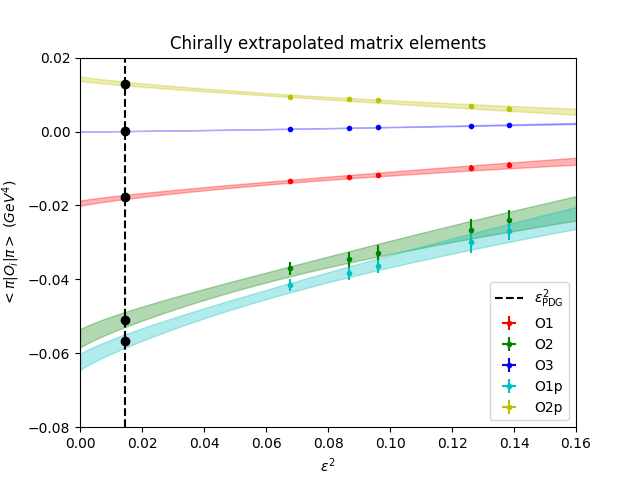

In [16]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

plt.figure()
for j in range(n_ops):
    plt.errorbar(eps_sq_sub_mu, mat_elems_sub_mu[j], xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                 c = colors[j], fmt = '.', label = labels[j])
    plt.fill_between(epsilon_sq_range[1:], band_data_mu[j] + band_data_sigma[j], band_data_mu[j] - band_data_sigma[j], \
                    color = colors[j], alpha = 0.3)
plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')
plt.legend(loc = 'lower right')
plt.xlim((0.0, 0.16))
plt.ylim((-0.08, 0.02))
plt.title('Chirally extrapolated matrix elements')
plt.xlabel('$\epsilon^2$')
# for some reason matplotlib breaks when we use \rangle in latex?
plt.ylabel('$<\pi|O_i|\pi>$ $(GeV^4)$')
plt.show()

In [17]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/chiral_extrap/my_mat_elems_davids_2pt.pdf')

## Notes

RESULTS FOR FITS TO THE MEAN

I generated fake data based on David's results for mpi and fpi and put them through the function which fits to their means-- it got pretty close to the values that his actual code spits out, when the L value was set to 32 each time. When I corrected the code it was still pretty close to what he had. Here's what David's code spits out:
O1
[-1.3102490330637617, -1.7066608393579843, -0.8422449312953697]
O2
[10.175257387129525, -4.966574781162899, -1.1703248819465772]
O3
[51.5038664286794, 0.6004464229091153, 1.7476029824455277]
O1p
[-1.5315739501273549, -5.489990421744237, -1.0860719237531953]
O2p
[7.343578513224973, 1.2660260632687053, -1.1274407384203236]

Here are the results from my code, using David's numbers to generate fake data, with L = 32 everywhere:
O1
[-1.20250871 -1.699562   -0.85025151]
O2
[10.24026743 -4.94628411 -1.17843114]
O3
[51.17464927  0.60353138  1.60246262]
O1p
[-1.44404244 -5.47414468 -1.10505762]
O2p
[ 7.44079538  1.26197142 -1.11098124]

And here are the results of my code, using David's numbers to generate fake data, with the correct value of L
O1
[-1.47760682 -1.6985531  -0.81686195]
O2
[ 9.98126654 -4.94366356 -1.14693482]
O3
[51.47078419  0.60335902  1.58085964]
O1p
[-1.71935554 -5.47075782 -1.07157295]
O2p
[ 7.17470892  1.26197194 -1.08468667]


Finally, if I use my data (with the correct value of L), I get a very different result. This is likely due to the fact that my fpi fits seem to give pretty different results-- need to check these and see what's going on. In the raw data, notice how the epsilon^2 values seem to be pretty different.
O1
[-7.16650898 -1.72766092 -0.17137882]
O2
[ 3.19326516 -4.9742111  -0.27528603]
O3
[43.60165803  0.63308699  1.39549587]
O1p
[-7.2709804  -5.5523971  -0.41884921]
O2p
[ 0.65288339  1.27018767 -0.2876572 ]

RESULTS FOR FITS TO THE FULL DATA WITH STATISTICS
David's numbers are in the notes he gave me. For the fake data, I generated fake ensembles with his numbers. I've saved plots from the chiral extrapolation in the folder research/0nubb/short_distance/chiral_extrap.

Results from my code using David's numbers to generate fake data, with L = 32 in f1: The plot for this is called 'david_data_buggy_code.pdf'. 
Fit parameters for operator O1
alpha = -1.1952923105750501 \pm 2.4232318685016687
beta = -1.6994125525843942 \pm 0.06894923313114809
c = -0.8478857721620399 \pm 0.42561839796501455
Fit parameters for operator O2
alpha = 10.25607199144804 \pm 3.237465976998419
beta = -4.945760266098866 \pm 0.25418046037910413
c = -1.1746486380349297 \pm 0.5360807050000578
Fit parameters for operator O3
alpha = 51.18682468116901 \pm 2.5406990329994716
beta = 0.6034953545922799 \pm 0.014862089003006899
c = 1.605380169186574 \pm 0.5921588562456657
Fit parameters for operator O1p
alpha = -1.437061479029064 \pm 2.36737668643327
beta = -5.4736652066393034 \pm 0.2175374717957628
c = -1.102885781343092 \pm 0.40934025689340536
Fit parameters for operator O2p
alpha = 7.442395660837931 \pm 0.6403661895226712
beta = 1.2619134184055125 \pm 0.014275051766372084
c = -1.1107447831821937 \pm 0.12393024098384445
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017695036164755037 \pm 0.00067868856980416
<pi|O2|pi> = -0.05122880377975424 \pm 0.002460141490902251
<pi|O3|pi> = 0.00011926473572161716 \pm 2.338028050502914e-06
<pi|O1p|pi> = -0.056763155854780624 \pm 0.0021450279659343215
<pi|O2p|pi> = 0.013084976490316787 \pm 0.00016967111307890042

Results from my code using David's numbers to generate fake data, with correct value of L in f1:
Fit parameters for operator O1
alpha = -1.4703869550032955 \pm 2.4232374162785835
beta = -1.6984031457401352 \pm 0.06880340920983277
c = -0.8144999249531516 \pm 0.4253689279117576
Fit parameters for operator O2
alpha = 9.997066827141868 \pm 3.2378708235836617
beta = -4.94313880822723 \pm 0.2537642907579481
c = -1.1431567921190475 \pm 0.5359239169173328
Fit parameters for operator O3
alpha = 51.48298021930898 \pm 2.543668509271114
beta = 0.6033305797019024 \pm 0.014884661038272625
c = 1.583327493709689 \pm 0.5932071339905192
Fit parameters for operator O1p
alpha = -1.7123706627798156 \pm 2.3674259990976902
beta = -5.470277244756541 \pm 0.21706558466921363
c = -1.0694054158129125 \pm 0.40910386276330585
Fit parameters for operator O2p
alpha = 7.176317790506278 \pm 0.6397362804138845
beta = 1.2619136971513203 \pm 0.014200927008520178
c = -1.0844519824046788 \pm 0.1236139068843035
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017693920897671796 \pm 0.0006777561883768293
<pi|O2|pi> = -0.05122744422013253 \pm 0.0024576851975487896
<pi|O3|pi> = 0.00011920018637870915 \pm 2.340104008053997e-06
<pi|O1p|pi> = -0.05675836741349343 \pm 0.0021419892665343818
<pi|O2p|pi> = 0.013090476037653698 \pm 0.00016916232505704334

Results from my code using my data, with correct value of L in f1:
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.01817977862601922 \pm 0.000537991979223405
<pi|O2|pi> = -0.052255283438707084 \pm 0.0018902251284648097
<pi|O3|pi> = 0.00012479699318107833 \pm 2.5914655655857415e-06
<pi|O1p|pi> = -0.058198972660061216 \pm 0.001722408726239742
<pi|O2p|pi> = 0.01334112508669661 \pm 0.0004690395619702873

Tests with David's data: Run the full analysis by taking David's data points in the document (note that he has saved data for this, but it's jackknifed, so instead I'll just generate fake bootstrapped ensembles) with both the buggy code (the one in David's script with the wrong value of L in f1) and the corrected code. Compare to David's values for the chiral extrapolation. Also note that even with using David's data, since I'm generating a different ensemble from his data it shouldn't match exactly, but it (especially the buggy output) should match his results up to uncertainty.